# Rome Monthly Temperature Forecasting – Ciampino Station (Full Project)

This notebook implements a complete **time–series forecasting project** for monthly weather data from the **Roma Ciampino** station (IT000016239), from **1951-01 to 2022-09**.

The dataset used here is the fully cleaned and completed file:

> `Roma_weather_noaa_full_months_filled.csv`

where:

- All missing months have been added and filled using **NOAA daily data**,
- All key variables (`TAVG`, `TMAX`, `TMIN`, `PRCP`, `DP01`, `DP10`, `DT32`, `DX32`, `DX90`) are available for every month.

We focus on forecasting **monthly average temperature (`TAVG`, in °C)**.

Models included (aligned with the course and fpp3):

- **Benchmark models**: mean, random walk with drift, seasonal naïve
- **SARIMA**: seasonal ARIMA for `TAVG` (with AIC/BIC grid search)
- **SARIMAX**: SARIMA with precipitation (`PRCP`) as an exogenous regressor
- **SARIMAX with cyclic month features**: SARIMA with deterministic seasonal regressors (sin/cos of month)
- **SARIMAX with seasonal + climate lags**: SARIMA with month_sin, month_cos, PRCP_lag1 and DX90_lag1 as exogenous regressors
- **SARIMAX with ENSO teleconnection**: SARIMA with lagged Niño 3.4 ENSO index (ENSO_lag1) as an exogenous regressor capturing large-scale climate variability
- **Evaluation**: 1-step-ahead forecasts on a holdout sample (last 20%), MSFE/MAFE
- **Diagnostics**: ADF tests, ACF/PACF, residual analysis, Ljung–Box test, histogram & Q-Q plots
- **Future forecasts**: 10-year-ahead forecasts of monthly temperature
- **Saving**: all relevant results, plots, diagnostics and models saved to disk


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 120

sm.__version__


'0.14.5'

## 2. Load and inspect the data

We use the fully cleaned, filled file:

> `Roma_weather_noaa_full_months_filled.csv`

Steps:

1. Read the file and parse `DATE` as datetime
2. Sort by date and set `DATE` as index
3. Enforce monthly frequency (`MS`)
4. Inspect structure and summary statistics


In [2]:
# Path to the cleaned, fully completed dataset (adjust if needed)
csv_path = "Roma_weather_noaa_full_months_filled.csv"

df = pd.read_csv(csv_path, parse_dates=["DATE"])
df = df.sort_values("DATE").set_index("DATE")
df = df.asfreq("MS")  # monthly start frequency

print("Date range:", df.index.min().date(), "to", df.index.max().date())
print("Number of observations:", len(df))

df.head()


# Cyclic month features (deterministic, for SARIMAX with time-of-year)
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


# Lagged exogenous features for SARIMAX
df['PRCP_lag1'] = df['PRCP'].shift(1)
df['DX90_lag1'] = df['DX90'].shift(1)

# ENSO index (Niño 3.4 anomalies) from local CSV
nino_path = "nina34.anom.csv"
try:
    enso_raw = pd.read_csv(nino_path, parse_dates=["Date"])
    # Identify the ENSO value column (everything except 'Date')
    enso_value_col = [c for c in enso_raw.columns if c != "Date"][0]
    enso = enso_raw[["Date", enso_value_col]].rename(columns={enso_value_col: "ENSO_index"})
    # Replace NOAA missing code (-9999) with NaN
    enso["ENSO_index"] = enso["ENSO_index"].replace(-9999.0, np.nan)
    enso = enso.set_index("Date").sort_index()
    enso = enso.asfreq("MS")
    # Join ENSO to main dataframe
    df = df.join(enso["ENSO_index"], how="left")
    # Lagged ENSO (one month lag)
    df["ENSO_lag1"] = df["ENSO_index"].shift(1)
    print("ENSO index merged. ENSO date range:", enso.index.min().date(), "to", enso.index.max().date())
except Exception as e:
    print("Warning: could not load ENSO index from", nino_path, "->", e)


Date range: 1951-01-01 to 2022-09-01
Number of observations: 861


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DP01,DP10,DT32,DX32,DX90,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,,,,,,,,
1951-01-01,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,12,7,0,0,0,87.1,9.7,13.6,5.8
1951-02-01,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,15,3,0,0,0,27.4,10.5,14.2,6.7
1951-03-01,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,12,5,4,0,0,43.5,10.6,15.4,5.9
1951-04-01,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,7,3,0,0,0,27.1,13.6,18.9,8.2
1951-05-01,IT000016239,"ROMA CIAMPINO, IT",41.7831,12.5831,105.0,9,5,0,0,0,40.7,16.6,21.6,11.6


In [3]:
print("\nBasic info:")
print(df.info())

print("\nSummary statistics for TAVG and PRCP:")
print(df[["TAVG", "PRCP"]].describe())



Basic info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 861 entries, 1951-01-01 to 2022-09-01
Freq: MS
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    861 non-null    object 
 1   NAME       861 non-null    object 
 2   LATITUDE   861 non-null    float64
 3   LONGITUDE  861 non-null    float64
 4   ELEVATION  861 non-null    float64
 5   DP01       861 non-null    int64  
 6   DP10       861 non-null    int64  
 7   DT32       861 non-null    int64  
 8   DX32       861 non-null    int64  
 9   DX90       861 non-null    int64  
 10  PRCP       861 non-null    float64
 11  TAVG       861 non-null    float64
 12  TMAX       861 non-null    float64
 13  TMIN       861 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 100.9+ KB
None

Summary statistics for TAVG and PRCP:
             TAVG        PRCP
count  861.000000  861.000000
mean    15.579443   61.416144
std      6.25682

In [4]:
print("Missing values per column:")
df.isna().sum()

Missing values per column:


STATION      0
NAME         0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
DP01         0
DP10         0
DT32         0
DX32         0
DX90         0
PRCP         0
TAVG         0
TMAX         0
TMIN         0
dtype: int64

## 3. Train–test split (80% / 20%)

We keep the **last 20%** of the sample as a **test set** for forecast evaluation.

- Training: first 80%
- Test: last 20%

We split **by time**.


In [5]:
n = len(df)
test_size = int(n * 0.2)

train = df.iloc[:-test_size].copy()
test  = df.iloc[-test_size:].copy()

print("Total observations:", n)
print(f"Train size: {len(train)} ({len(train)/n:.1%})",
      train.index.min().date(), "to", train.index.max().date())
print(f"Test size:  {len(test)} ({len(test)/n:.1%})",
      test.index.min().date(), "to", test.index.max().date())

y = df["TAVG"]
y_train = train["TAVG"]
y_test  = test["TAVG"]

Total observations: 861
Train size: 689 (80.0%) 1951-01-01 to 2008-05-01
Test size:  172 (20.0%) 2008-06-01 to 2022-09-01


## 4. Exploratory data analysis

### 4.1 Time series plot of TAVG

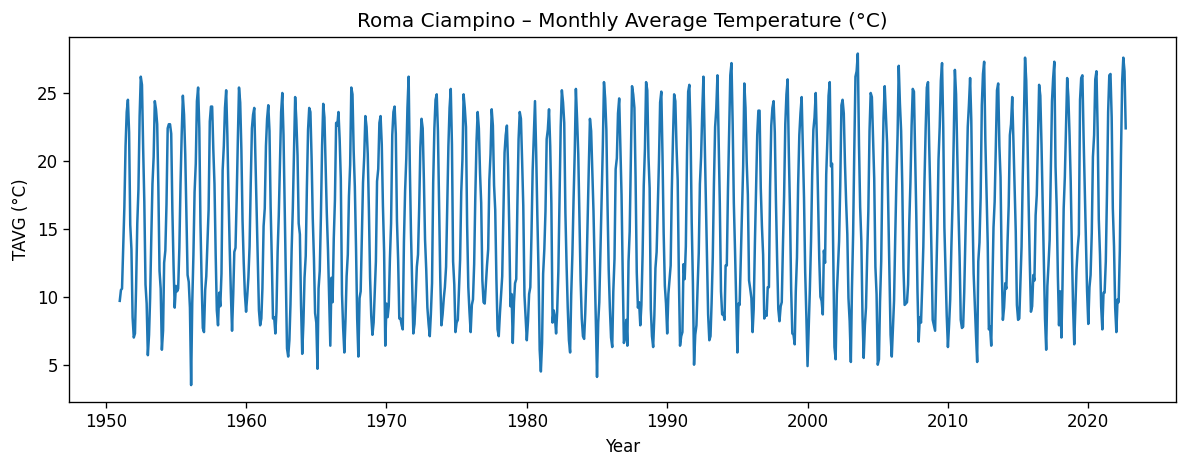

In [6]:
plt.figure()
plt.plot(df.index, df["TAVG"])
plt.title("Roma Ciampino – Monthly Average Temperature (°C)")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.tight_layout()
plt.show()

### 4.2 Seasonal pattern by month

<Figure size 960x480 with 0 Axes>

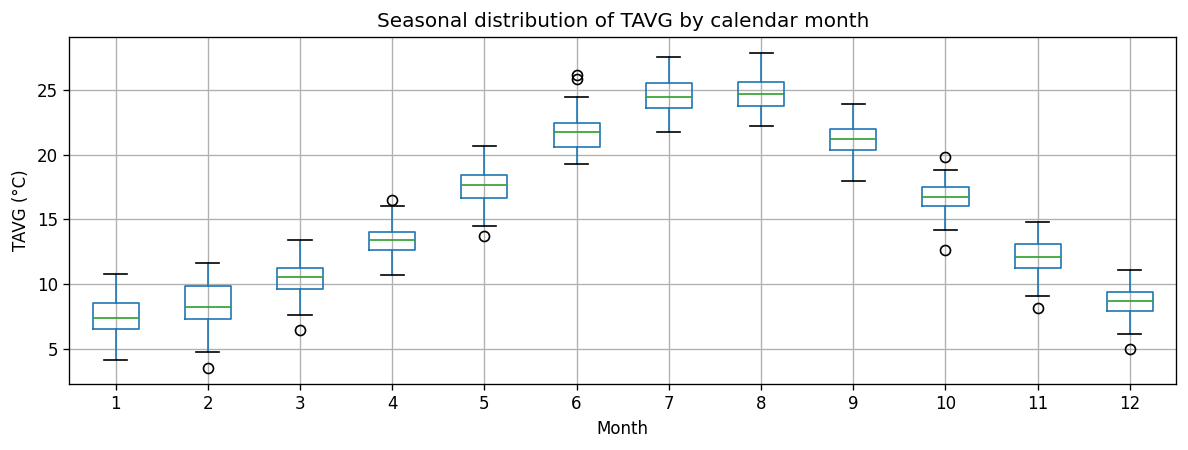

In [7]:
tmp = df.copy()
tmp["month"] = tmp.index.month

plt.figure(figsize=(8, 4))
tmp.boxplot(column="TAVG", by="month")
plt.suptitle("")
plt.title("Seasonal distribution of TAVG by calendar month")
plt.xlabel("Month")
plt.ylabel("TAVG (°C)")
plt.tight_layout()
plt.show()

## 5. Stationarity and dependence structure

We run ADF tests on levels and differences and inspect ACFs.

In [8]:
def adf_report(series, label):
    res = adfuller(series.dropna())
    stat, pval = res[0], res[1]
    print(f"{label:25s} ADF stat = {stat:8.3f}, p-value = {pval:.3g}")

print("ADF tests for TAVG (on full sample):")
adf_report(y, "Level")
adf_report(y.diff(), "1st difference")
adf_report(y.diff(12), "Seasonal diff (lag 12)")
adf_report(y.diff().diff(12), "1st + seasonal diff")

ADF tests for TAVG (on full sample):
Level                     ADF stat =   -3.816, p-value = 0.00275
1st difference            ADF stat =  -11.343, p-value = 1.05e-20
Seasonal diff (lag 12)    ADF stat =  -12.567, p-value = 2.05e-23
1st + seasonal diff       ADF stat =  -12.096, p-value = 2.07e-22


<Figure size 1200x480 with 0 Axes>

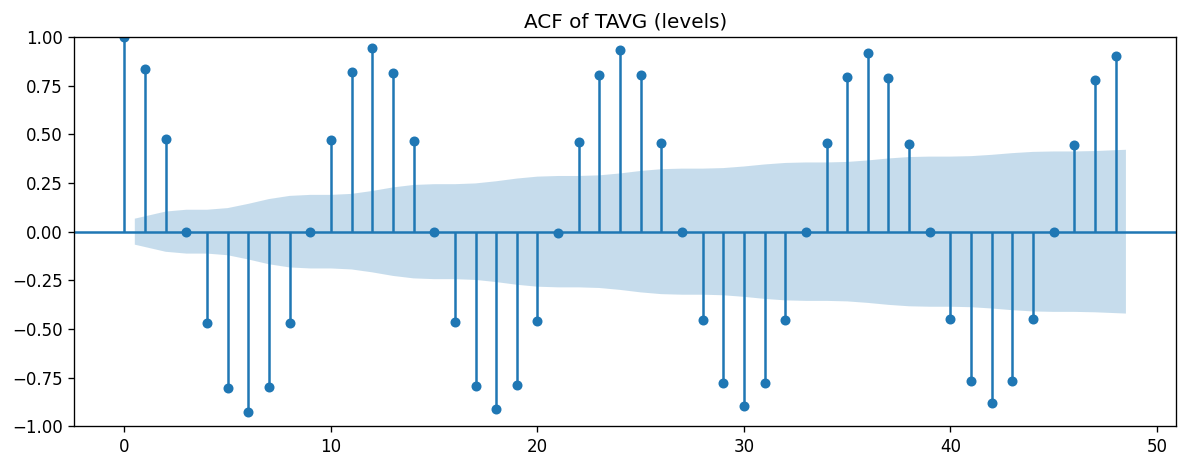

<Figure size 1200x480 with 0 Axes>

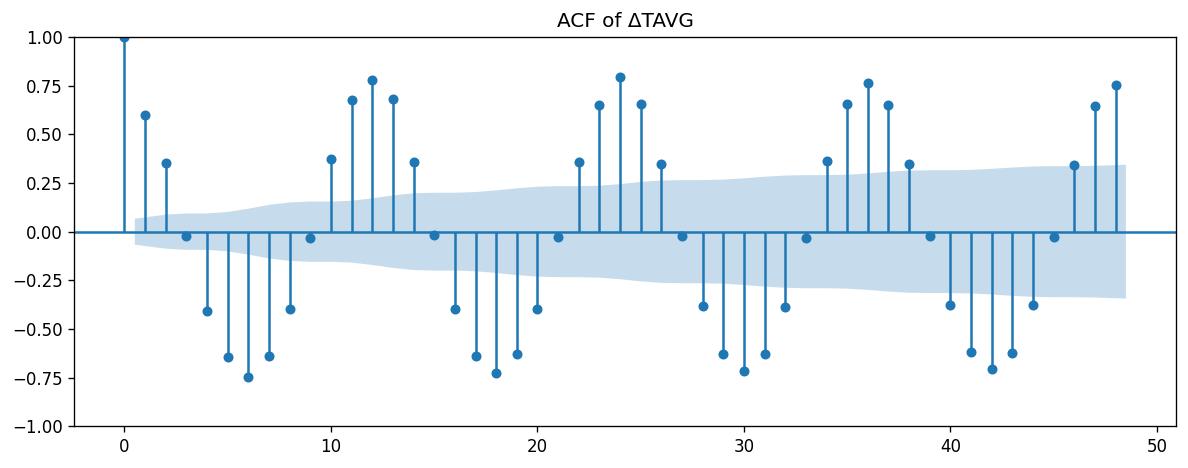

<Figure size 1200x480 with 0 Axes>

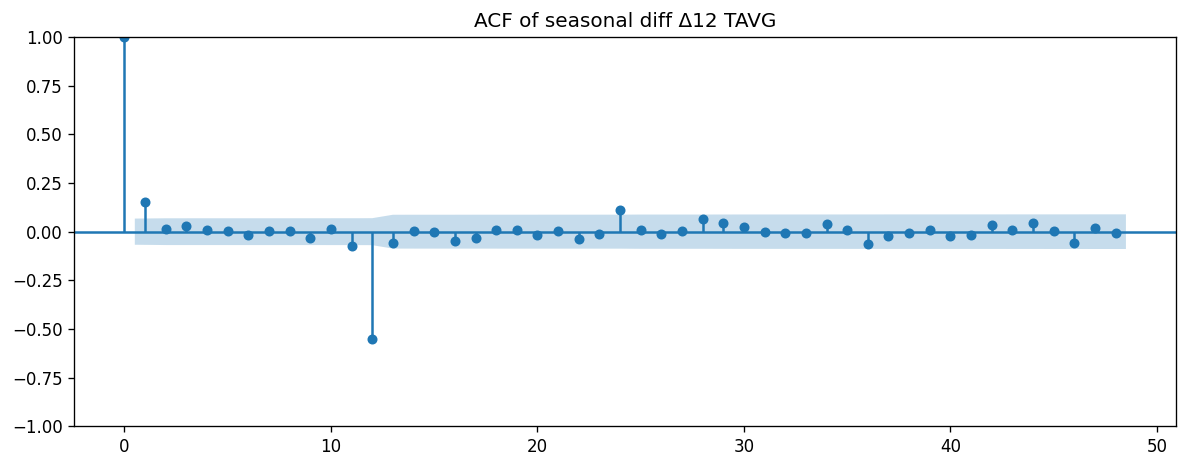

In [9]:
# ACF of levels
plt.figure()
plot_acf(y.dropna(), lags=48)
plt.title("ACF of TAVG (levels)")
plt.tight_layout()
plt.show()

# ACF of first difference
plt.figure()
plot_acf(y.diff().dropna(), lags=48)
plt.title("ACF of ΔTAVG")
plt.tight_layout()
plt.show()

# ACF of seasonal difference
plt.figure()
plot_acf(y.diff(12).dropna(), lags=48)
plt.title("ACF of seasonal diff Δ12 TAVG")
plt.tight_layout()
plt.show()

## 6. Benchmark models (mean, random walk, seasonal naïve)

We construct three simple models:

1. **Mean**
2. **Random walk with drift**
3. **Seasonal naïve (m = 12)**

In [10]:
# Helper functions
def msfe(actual, forecast):
    e = actual - forecast
    return np.mean(e**2)

def mafe(actual, forecast):
    e = actual - forecast
    return np.mean(np.abs(e))

# 1) Mean model
mean_level = y_train.mean()
mean_forecast = pd.Series(mean_level, index=y_test.index)

# 2) Random walk with drift
drift = (y_train.iloc[-1] - y_train.iloc[0]) / (len(y_train) - 1)
h = np.arange(1, len(y_test) + 1)
rwd_forecast = y_train.iloc[-1] + drift * h
rwd_forecast = pd.Series(rwd_forecast, index=y_test.index)

# 3) Seasonal naïve (m = 12)
m = 12
seasonal_naive = []
for i, idx in enumerate(y_test.index):
    same_month_train = y_train[y_train.index.month == idx.month]
    seasonal_naive.append(same_month_train.iloc[-1])
seasonal_naive = pd.Series(seasonal_naive, index=y_test.index)

# Collect metrics for benchmarks
metrics_bench = pd.DataFrame({
    "Model": ["Mean", "RW_with_drift", "Seasonal_naive"],
    "MSFE": [
        msfe(y_test, mean_forecast),
        msfe(y_test, rwd_forecast),
        msfe(y_test, seasonal_naive),
    ],
    "MAFE": [
        mafe(y_test, mean_forecast),
        mafe(y_test, rwd_forecast),
        mafe(y_test, seasonal_naive),
    ],
})
metrics_bench

,Model,MSFE,MAFE
0,Mean,43.875249,5.762059
1,RW_with_drift,52.487046,6.305760
2,Seasonal_naive,2.706919,1.342442


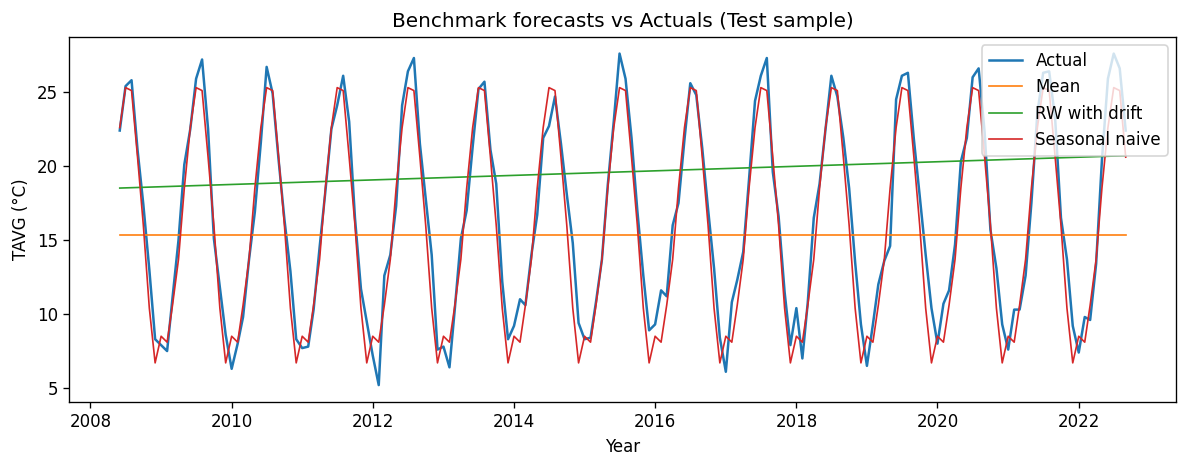

In [11]:
plt.figure()
plt.plot(y_test.index, y_test, label="Actual", lw=1.5)
plt.plot(mean_forecast.index, mean_forecast, label="Mean", lw=1)
plt.plot(rwd_forecast.index, rwd_forecast, label="RW with drift", lw=1)
plt.plot(seasonal_naive.index, seasonal_naive, label="Seasonal naive", lw=1)
plt.title("Benchmark forecasts vs Actuals (Test sample)")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.legend()
plt.tight_layout()
plt.show()

## 7. SARIMA model selection (AIC/BIC grid search)

We consider SARIMA(p,1,q)(P,1,Q)[12] with:

- p, q ∈ {0,1,2}
- P, Q ∈ {0,1}

In [12]:
p_values = [0, 1, 2]
q_values = [0, 1, 2]
P_values = [0, 1]
Q_values = [0, 1]

sarima_grid = []

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, 1, q)
                seasonal_order = (P, 1, Q, 12)
                try:
                    model = SARIMAX(
                        y_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend="c",
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    )
                    res = model.fit(disp=False)
                    sarima_grid.append({
                        "p": p, "d": 1, "q": q,
                        "P": P, "D": 1, "Q": Q,
                        "AIC": res.aic,
                        "BIC": res.bic,
                    })
                except Exception:
                    sarima_grid.append({
                        "p": p, "d": 1, "q": q,
                        "P": P, "D": 1, "Q": Q,
                        "AIC": np.nan,
                        "BIC": np.nan,
                    })

sarima_grid = pd.DataFrame(sarima_grid)
sarima_grid_sorted = sarima_grid.sort_values("AIC").reset_index(drop=True)
sarima_grid_sorted.head(10)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

,p,d,q,P,D,Q,AIC,BIC
0,0,1,2,0,1,1,2221.990516,2244.459285
1,2,1,1,0,1,1,2223.848143,2250.819737
2,1,1,1,0,1,1,2225.023660,2247.499987
3,2,1,2,0,1,1,2225.601035,2257.057312
4,0,1,2,1,1,1,2228.891381,2255.853904
5,1,1,2,0,1,1,2230.919966,2257.882489
6,1,1,1,1,1,1,2235.623806,2262.595399
7,2,1,1,1,1,1,2239.316332,2270.783191
8,2,1,2,1,1,1,2240.594730,2276.544760
9,1,1,2,1,1,1,2246.176789,2277.633066


In [13]:
best_row = sarima_grid_sorted.iloc[0]
best_order = (int(best_row["p"]), int(best_row["d"]), int(best_row["q"]))
best_seasonal_order = (int(best_row["P"]), int(best_row["D"]), int(best_row["Q"]), 12)

print("Best SARIMA order by AIC:")
print("order =", best_order, ", seasonal_order =", best_seasonal_order)

Best SARIMA order by AIC:
order = (0, 1, 2) , seasonal_order = (0, 1, 1, 12)


## 8. SARIMA and SARIMAX (with precipitation)

In [14]:
sarima_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 TAVG   No. Observations:                  689
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1105.995
Date:                              Tue, 18 Nov 2025   AIC                           2221.991
Time:                                      00:32:02   BIC                           2244.459
Sample:                                  01-01-1951   HQIC                          2230.699
                                       - 05-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   6.02e-05      3.173      0.002    7.31e-05       0.000
ma.L1         -0.79

/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
exog_train = train[["PRCP"]]
exog_test = test[["PRCP"]]

sarimax_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_train,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 TAVG   No. Observations:                  689
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1105.025
Date:                              Tue, 18 Nov 2025   AIC                           2222.049
Time:                                      00:32:03   BIC                           2249.012
Sample:                                  01-01-1951   HQIC                          2232.499
                                       - 05-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   6.05e-05      3.068      0.002    6.71e-05       0.000
PRCP          -0.00

In [ ]:
# SARIMAX with cyclic month features (sin/cos)
exog_month_train = train[["month_sin", "month_cos"]]
exog_month_test = test[["month_sin", "month_cos"]]

sarimax_month_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_month_train,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarimax_month_model.summary())

In [ ]:
# SARIMAX with seasonal and climate exogenous variables
# Exogenous regressors: month_sin, month_cos, PRCP_lag1, DX90_lag1
exog_all_train_full = train[["month_sin", "month_cos", "PRCP_lag1", "DX90_lag1"]]
exog_all_test = test[["month_sin", "month_cos", "PRCP_lag1", "DX90_lag1"]]

# Drop initial training observations where lagged exogenous variables are missing
mask_all_train = np.isfinite(exog_all_train_full).all(axis=1)
exog_all_train = exog_all_train_full.loc[mask_all_train]
y_train_all = y_train.loc[mask_all_train]

sarimax_all_model = SARIMAX(
    y_train_all,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_all_train,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarimax_all_model.summary())

In [ ]:
# SARIMAX with ENSO_lag1 as exogenous regressor
# ENSO_lag1 captures large-scale climate variability with a one-month lag

exog_enso_train_full = train[["ENSO_lag1"]]
exog_enso_test = test[["ENSO_lag1"]]

# Drop training rows where ENSO_lag1 is missing
mask_enso_train = np.isfinite(exog_enso_train_full).all(axis=1)
exog_enso_train = exog_enso_train_full.loc[mask_enso_train]
y_train_enso = y_train.loc[mask_enso_train]

sarimax_enso_model = SARIMAX(
    y_train_enso,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_enso_train,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(sarimax_enso_model.summary())

## 9. Residual diagnostics (SARIMA & SARIMAX)

In [16]:
def residual_diagnostics(res, model_name="Model"):
    resid = res.resid.dropna()

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Residual time plot
    axes[0,0].plot(resid)
    axes[0,0].axhline(0, ls="--", color="k")
    axes[0,0].set_title(f"Residuals over time – {model_name}")

    # ACF of residuals
    plot_acf(resid, lags=36, ax=axes[0,1])
    axes[0,1].set_title(f"ACF of residuals – {model_name}")

    # Histogram + normal pdf overlay
    axes[1,0].hist(resid, bins=20, density=True, alpha=0.6)
    mu, sigma = resid.mean(), resid.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    axes[1,0].plot(x, stats.norm.pdf(x, mu, sigma))
    axes[1,0].set_title(f"Residual histogram – {model_name}")

    # Q–Q plot
    stats.probplot(resid, dist="norm", plot=axes[1,1])
    axes[1,1].set_title(f"Normal Q–Q plot – {model_name}")

    plt.tight_layout()
    plt.show()

    # Ljung–Box test at lag 12
    lb = acorr_ljungbox(resid, lags=[12], return_df=True)
    print(f"Ljung–Box test (lag 12) for {model_name}:")
    print(lb)
    print("\n")

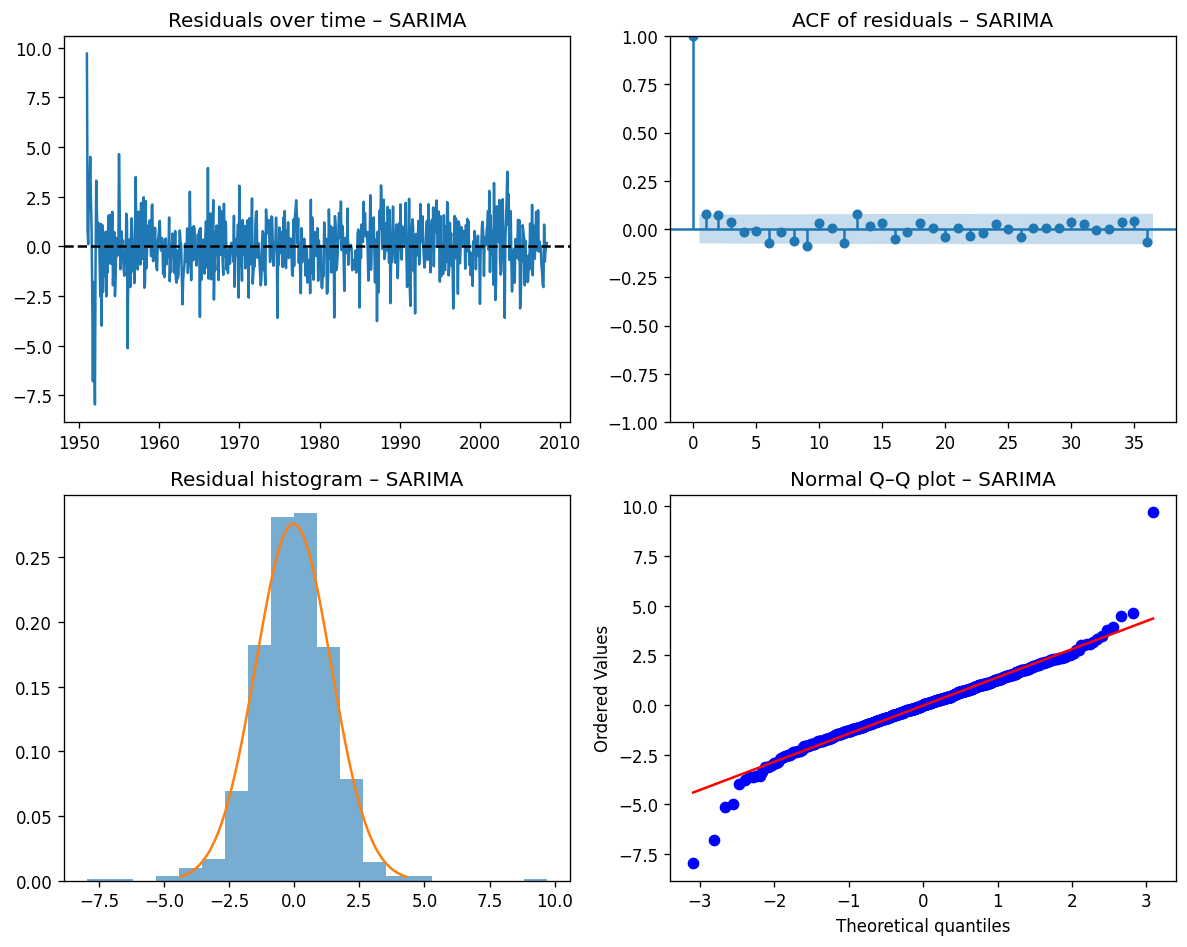

Ljung–Box test (lag 12) for SARIMA:
      lb_stat  lb_pvalue
12  25.312163   0.013411




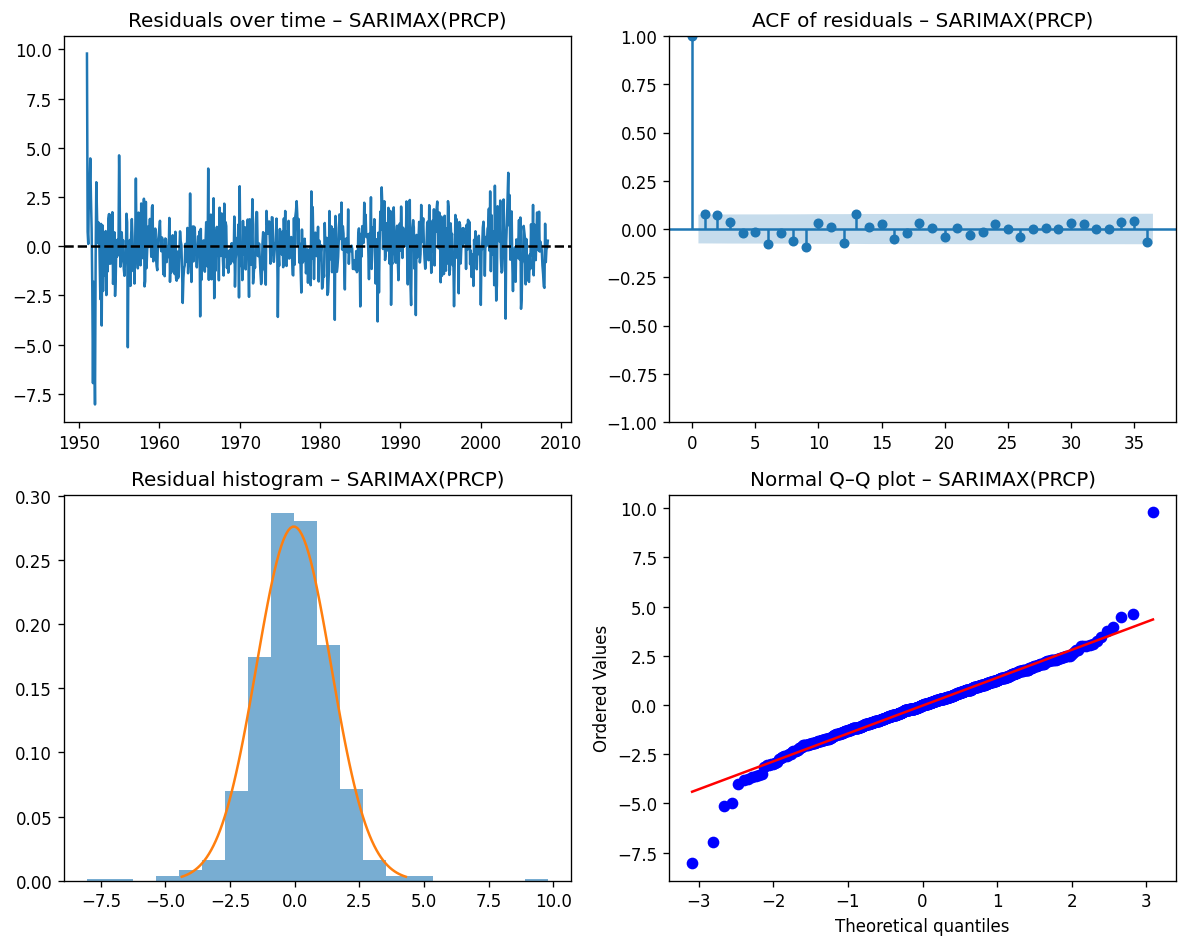

Ljung–Box test (lag 12) for SARIMAX(PRCP):
      lb_stat  lb_pvalue
12  26.532811   0.009016




In [17]:
residual_diagnostics(sarima_model, model_name="SARIMA")
residual_diagnostics(sarimax_model, model_name="SARIMAX(PRCP)")
residual_diagnostics(sarimax_month_model, model_name="SARIMAX(MonthCyc)")
residual_diagnostics(sarimax_all_model, model_name="SARIMAX(Season+PRCP1+DX90_1)")
residual_diagnostics(sarimax_enso_model, model_name="SARIMAX(ENSO_lag1)")


## 11. 1-step-ahead forecast evaluation (all models)

In [ ]:
# SARIMA forecasts
sarima_pred = sarima_model.get_forecast(steps=len(y_test))
sarima_fc = sarima_pred.predicted_mean
sarima_fc.index = y_test.index

# SARIMAX forecasts with precipitation
sarimax_pred = sarimax_model.get_forecast(steps=len(y_test), exog=exog_test)
sarimax_fc = sarimax_pred.predicted_mean
sarimax_fc.index = y_test.index

# SARIMAX forecasts with cyclic month features
sarimax_month_pred = sarimax_month_model.get_forecast(steps=len(y_test), exog=exog_month_test)
sarimax_month_fc = sarimax_month_pred.predicted_mean
sarimax_month_fc.index = y_test.index

# SARIMAX forecasts with full exogenous set (seasonality + PRCP_lag1 + DX90_lag1)
sarimax_all_pred = sarimax_all_model.get_forecast(steps=len(y_test), exog=exog_all_test)
sarimax_all_fc = sarimax_all_pred.predicted_mean
sarimax_all_fc.index = y_test.index

# SARIMAX forecasts with ENSO_lag1
sarimax_enso_pred = sarimax_enso_model.get_forecast(steps=len(y_test), exog=exog_enso_test)
sarimax_enso_fc = sarimax_enso_pred.predicted_mean
sarimax_enso_fc.index = y_test.index

def rmsfe(e):
    return np.sqrt(np.mean(e**2))

def mafe(e):
    return np.mean(np.abs(e))

rows = []

# Benchmarks
rows.append({
    "Model": "Mean",
    "RMSFE": rmsfe(y_test - mean_forecast),
    "MAFE": mafe(y_test - mean_forecast),
})
rows.append({
    "Model": "RW_with_drift",
    "RMSFE": rmsfe(y_test - rwd_forecast),
    "MAFE": mafe(y_test - rwd_forecast),
})
rows.append({
    "Model": "Seasonal_naive",
    "RMSFE": rmsfe(y_test - seasonal_naive),
    "MAFE": mafe(y_test - seasonal_naive),
})

# SARIMA & SARIMAX models
rows.append({
    "Model": "SARIMA",
    "RMSFE": rmsfe(y_test - sarima_fc),
    "MAFE": mafe(y_test - sarima_fc),
})
rows.append({
    "Model": "SARIMAX_PRCP",
    "RMSFE": rmsfe(y_test - sarimax_fc),
    "MAFE": mafe(y_test - sarimax_fc),
})
rows.append({
    "Model": "SARIMAX_MonthCyc",
    "RMSFE": rmsfe(y_test - sarimax_month_fc),
    "MAFE": mafe(y_test - sarimax_month_fc),
})
rows.append({
    "Model": "SARIMAX_FourExog",
    "RMSFE": rmsfe(y_test - sarimax_all_fc),
    "MAFE": mafe(y_test - sarimax_all_fc),
})
rows.append({
    "Model": "SARIMAX_ENSO_lag1",
    "RMSFE": rmsfe(y_test - sarimax_enso_fc),
    "MAFE": mafe(y_test - sarimax_enso_fc),
})

metrics_all = pd.DataFrame(rows)
metrics_all


In [ ]:
plt.figure()
plt.plot(y_test.index, y_test, label="Actual", lw=1.5)
plt.plot(seasonal_naive.index, seasonal_naive, label="Seasonal naive", lw=1)
plt.plot(sarima_fc.index, sarima_fc, label="SARIMA", lw=1)
plt.plot(sarimax_fc.index, sarimax_fc, label="SARIMAX(PRCP)", lw=1)
plt.plot(sarimax_month_fc.index, sarimax_month_fc, label="SARIMAX(MonthCyc)", lw=1)
plt.plot(sarimax_all_fc.index, sarimax_all_fc, label="SARIMAX(FourExog)", lw=1)
plt.plot(sarimax_enso_fc.index, sarimax_enso_fc, label="SARIMAX(ENSO_lag1)", lw=1)
plt.title("1-step-ahead forecasts vs Actuals (Test sample)")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.legend()
plt.tight_layout()
plt.show()


## 12. Future temperature forecasts (10 years ahead)

In [ ]:
# Refit SARIMA on full sample
sarima_full = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal_order,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Refit SARIMAX on full sample with precipitation
exog_full = df[["PRCP"]]
sarimax_full = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_full,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Refit SARIMAX on full sample with cyclic month features
exog_month_full = df[["month_sin", "month_cos"]]
sarimax_month_full = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_month_full,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Refit SARIMAX on full sample with four exogenous variables
exog_all_full = df[["month_sin", "month_cos", "PRCP_lag1", "DX90_lag1"]]
mask_all_full = np.isfinite(exog_all_full).all(axis=1)
exog_all_full_clean = exog_all_full.loc[mask_all_full]
y_all_full = y.loc[mask_all_full]

sarimax_all_full = SARIMAX(
    y_all_full,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_all_full_clean,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Refit SARIMAX on full sample with ENSO_lag1
exog_enso_full = df[["ENSO_lag1"]]
mask_enso_full = np.isfinite(exog_enso_full).all(axis=1)
exog_enso_full_clean = exog_enso_full.loc[mask_enso_full]
y_enso_full = y.loc[mask_enso_full]

sarimax_enso_full = SARIMAX(
    y_enso_full,
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=exog_enso_full_clean,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print("Full-sample AIC (SARIMA):", sarima_full.aic)
print("Full-sample AIC (SARIMAX_PRCP):", sarimax_full.aic)
print("Full-sample AIC (SARIMAX_MonthCyc):", sarimax_month_full.aic)
print("Full-sample AIC (SARIMAX_FourExog):", sarimax_all_full.aic)
print("Full-sample AIC (SARIMAX_ENSO_lag1):", sarimax_enso_full.aic)


In [ ]:
# Build future date index: 10 years of monthly data
years_ahead = 10
last_date = df.index.max()
steps_ahead = years_ahead * 12

future_index = pd.date_range(
    last_date + pd.offsets.MonthBegin(1),
    periods=steps_ahead,
    freq="MS"
)
future_index[:5]

In [ ]:
# Normal-precipitation scenario: mean PRCP by calendar month
monthly_clim_prcp = df["PRCP"].groupby(df.index.month).mean()
future_prcp = [monthly_clim_prcp[d.month] for d in future_index]
exog_future = pd.DataFrame({"PRCP": future_prcp}, index=future_index)

# Cyclic month features for future horizon
future_month = future_index.month
exog_future_month = pd.DataFrame({
    "month_sin": np.sin(2 * np.pi * future_month / 12),
    "month_cos": np.cos(2 * np.pi * future_month / 12),
}, index=future_index)

exog_future.head()


In [ ]:
# Future forecasts from SARIMA and SARIMAX family
sarima_future = sarima_full.get_forecast(steps=steps_ahead)
fc_sarima_future = sarima_future.predicted_mean
fc_sarima_future.index = future_index

sarimax_future = sarimax_full.get_forecast(steps=steps_ahead, exog=exog_future)
fc_sarimax_future = sarimax_future.predicted_mean
fc_sarimax_future.index = future_index

sarimax_month_future = sarimax_month_full.get_forecast(steps=steps_ahead, exog=exog_future_month)
fc_sarimax_month_future = sarimax_month_future.predicted_mean
fc_sarimax_month_future.index = future_index

fc_sarima_future.head(), fc_sarimax_future.head(), fc_sarimax_month_future.head()


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["TAVG"], label="Historical TAVG", lw=1)
plt.plot(fc_sarima_future.index, fc_sarima_future,
         label="SARIMA future forecast", ls="--")
plt.plot(fc_sarimax_future.index, fc_sarimax_future,
         label="SARIMAX(PRCP) future\n(normal PRCP scenario)", ls="--")
plt.plot(fc_sarimax_month_future.index, fc_sarimax_month_future,
         label="SARIMAX(MonthCyc) future", ls="--")
plt.axvline(df.index.max(), color="k", ls=":", label="Forecast origin")
plt.title("Roma Ciampino – Monthly Average Temperature: Historical and 10-year Forecast")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.legend()
plt.tight_layout()
plt.show()


## 13. Save all results

This cell saves:

- data (full, train, test)
- metrics tables
- forecast tables
- ADF diagnostics
- residuals
- plots
- model summaries and objects

to a `results_full/` folder.

In [ ]:
from pathlib import Path
import json
import joblib
from statsmodels.tsa.stattools import adfuller

# ------------------------------------------------------------
# 0. Create directory structure
# ------------------------------------------------------------
root = Path("results_full")
dirs = {
    "data": root / "data",
    "tables": root / "tables",
    "plots": root / "plots",
    "models": root / "models",
    "diagnostics": root / "diagnostics",
}

for d in dirs.values():
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. SAVE DATA
# ============================================================
df.to_csv(dirs["data"] / "roma_weather_noaa_full_months_filled_with_features.csv")

# ============================================================
# 2. SAVE TABLES (METRICS & FORECASTS)
# ============================================================

# Metrics
metrics_all.to_csv(dirs["tables"] / "forecast_metrics_test_all_models.csv", index=False)
metrics_bench.to_csv(dirs["tables"] / "forecast_metrics_benchmarks.csv", index=False)
sarima_grid_sorted.to_csv(dirs["tables"] / "sarima_grid_aic_bic.csv", index=False)

# Core models test forecasts
df_test_results = pd.DataFrame({
    "DATE": y_test.index,
    "TAVG_actual": y_test.values,
    "TAVG_fc_mean": mean_forecast.values,
    "TAVG_fc_rw_drift": rwd_forecast.values,
    "TAVG_fc_seasonal_naive": seasonal_naive.values,
    "TAVG_fc_sarima": sarima_fc.values,
    "TAVG_fc_sarimax_prcp": sarimax_fc.values,
    "TAVG_fc_sarimax_monthcyc": sarimax_month_fc.values,
    "TAVG_fc_sarimax_fourexog": sarimax_all_fc.values,
    "TAVG_fc_sarimax_enso_lag1": sarimax_enso_fc.values,
}).set_index("DATE")
df_test_results.to_csv(dirs["tables"] / "test_forecasts_core_models.csv")
# Future forecasts (10-year ahead)
df_future_results = pd.DataFrame({
    "DATE": fc_sarima_future.index,
    "TAVG_fc_sarima": fc_sarima_future.values,
    "TAVG_fc_sarimax_prcp": fc_sarimax_future.values,
    "TAVG_fc_sarimax_monthcyc": fc_sarimax_month_future.values,
}).set_index("DATE")
df_future_results.to_csv(dirs["tables"] / "future_forecasts_10y_tavg.csv")

print("Saved metrics and forecast tables.")

# ============================================================
# 3. SAVE DIAGNOSTICS (BASIC)
# ============================================================

diagnostics = {}

def adf_summary(series):
    stat, pval, lags, nobs, crit_vals, icbest = adfuller(series.dropna())
    return {
        "statistic": float(stat),
        "pvalue": float(pval),
        "lags": int(lags),
        "nobs": int(nobs),
        "crit_values": {k: float(v) for k, v in crit_vals.items()},
    }

diagnostics["adf_TAVG"] = adf_summary(y)

with open(dirs["diagnostics"] / "diagnostics_basic.json", "w") as f:
    json.dump(diagnostics, f, indent=2)

print("Saved basic diagnostics.")

# ============================================================
# 4. SAVE A FEW KEY PLOTS
# ============================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def save_and_close(fig, path):
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)

# Time series plot
fig = plt.figure(figsize=(10, 4))
plt.plot(df.index, df["TAVG"])
plt.title("Roma Ciampino – Monthly Average Temperature (°C)")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.tight_layout()
save_and_close(fig, dirs["plots"] / "tavg_timeseries.png")

# Test forecast plot
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label="Actual", lw=1.5)
plt.plot(seasonal_naive.index, seasonal_naive, label="Seasonal naive", lw=1)
plt.plot(sarima_fc.index, sarima_fc, label="SARIMA", lw=1)
plt.plot(sarimax_fc.index, sarimax_fc, label="SARIMAX(PRCP)", lw=1)
plt.plot(sarimax_month_fc.index, sarimax_month_fc, label="SARIMAX(MonthCyc)", lw=1)
plt.plot(sarimax_all_fc.index, sarimax_all_fc, label="SARIMAX(FourExog)", lw=1)
plt.plot(sarimax_enso_fc.index, sarimax_enso_fc, label="SARIMAX(ENSO_lag1)", lw=1)
plt.title("1-step-ahead forecasts vs Actuals (Test sample)")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.legend()
plt.tight_layout()
save_and_close(fig, dirs["plots"] / "test_forecasts_tavg.png")

# Future forecast plot
fig = plt.figure(figsize=(12, 5))
plt.plot(df.index, df["TAVG"], label="Historical TAVG", lw=1)
plt.plot(fc_sarima_future.index, fc_sarima_future,
         label="SARIMA future forecast", ls="--")
plt.plot(fc_sarimax_future.index, fc_sarimax_future,
         label="SARIMAX(PRCP) future\n(normal PRCP scenario)", ls="--")
plt.plot(fc_sarimax_month_future.index, fc_sarimax_month_future,
         label="SARIMAX(MonthCyc) future", ls="--")
plt.axvline(df.index.max(), color="k", ls=":", label="Forecast origin")
plt.title("Roma Ciampino – Monthly Average Temperature: Historical and 10-year Forecast")
plt.xlabel("Year")
plt.ylabel("TAVG (°C)")
plt.legend()
plt.tight_layout()
save_and_close(fig, dirs["plots"] / "future_forecasts_10y_tavg.png")

print("Saved plots.")

# ============================================================
# 5. SAVE MODEL SUMMARIES & OBJECTS
# ============================================================

with open(dirs["models"] / "sarima_train_summary.txt", "w") as f:
    f.write(str(sarima_model.summary()))

with open(dirs["models"] / "sarimax_prcp_train_summary.txt", "w") as f:
    f.write(str(sarimax_model.summary()))

with open(dirs["models"] / "sarimax_month_train_summary.txt", "w") as f:
    f.write(str(sarimax_month_model.summary()))

with open(dirs["models"] / "sarimax_fourexog_train_summary.txt", "w") as f:
    f.write(str(sarimax_all_model.summary()))

with open(dirs["models"] / "sarima_full_summary.txt", "w") as f:
    f.write(str(sarima_full.summary()))

with open(dirs["models"] / "sarimax_prcp_full_summary.txt", "w") as f:
    f.write(str(sarimax_full.summary()))

with open(dirs["models"] / "sarimax_month_full_summary.txt", "w") as f:
    f.write(str(sarimax_month_full.summary()))

with open(dirs["models"] / "sarimax_fourexog_full_summary.txt", "w") as f:
    f.write(str(sarimax_all_full.summary()))

with open(dirs["models"] / "sarimax_enso_train_summary.txt", "w") as f:
    f.write(str(sarimax_enso_model.summary()))

with open(dirs["models"] / "sarimax_enso_full_summary.txt", "w") as f:
    f.write(str(sarimax_enso_full.summary()))

joblib.dump(sarima_model,  dirs["models"] / "sarima_train.joblib")
joblib.dump(sarimax_model, dirs["models"] / "sarimax_prcp_train.joblib")
joblib.dump(sarimax_month_model, dirs["models"] / "sarimax_month_train.joblib")
joblib.dump(sarimax_all_model, dirs["models"] / "sarimax_fourexog_train.joblib")
joblib.dump(sarimax_enso_model, dirs["models"] / "sarimax_enso_train.joblib")

joblib.dump(sarima_full,   dirs["models"] / "sarima_full.joblib")
joblib.dump(sarimax_full,  dirs["models"] / "sarimax_prcp_full.joblib")
joblib.dump(sarimax_month_full, dirs["models"] / "sarimax_month_full.joblib")
joblib.dump(sarimax_all_full,   dirs["models"] / "sarimax_fourexog_full.joblib")
joblib.dump(sarimax_enso_full,  dirs["models"] / "sarimax_enso_full.joblib")

print("Saved model summaries and objects.")
print("\n✅ All key data, metrics, forecasts, plots, diagnostics, and models have been saved.")
